## Project 3 Prompt

**Dataset(s) to be used:**

1. Daily Bitcoin price data (BTC-USD) from Yahoo Finance, downloaded via `yfinance` and saved locally as `bitcoin_daily.csv`.  
2. Daily S&P 500 index price data (^GSPC) from Yahoo Finance, downloaded via `yfinance` and saved locally as `sp500_daily.csv`.  

(Original sources:  
- BTC-USD: https://finance.yahoo.com/quote/BTC-USD/history  
- ^GSPC: https://finance.yahoo.com/quote/%5EGSPC/history)

---

**Analysis question:**

Has Bitcoin become increasingly correlated with the U.S. stock market (S&P 500 index) over time between 2015 and 2025?

---

**Columns that will (likely) be used:**

From the Bitcoin dataset (`bitcoin_daily.csv`):
- `Price` (to be renamed `Date`)
- `Close` (to be renamed `btc_close`)
- `High` (optional, for descriptive stats)
- `Low` (optional, for descriptive stats)
- `Open` (optional, for descriptive stats)
- `Volume` (to be renamed `btc_volume`, optional)

From the S&P 500 dataset (`sp500_daily.csv`):
- `Price` (to be renamed `Date`)
- `Close` (to be renamed `sp_close`)
- `High` (optional)
- `Low` (optional)
- `Open` (optional)
- `Volume` (to be renamed `sp_volume`, optional)

Computed columns (created in the notebook):
- `btc_ret`: daily percentage returns for Bitcoin
- `sp_ret`: daily percentage returns for the S&P 500
- `corr_90d`: 90-day rolling correlation between `btc_ret` and `sp_ret`
- (Possibly) `corr_180d`, `corr_365d` for longer windows

---

**Columns to be used to merge/join them:**

- Bitcoin dataset: `Date` (renamed from `Price`)
- S&P 500 dataset: `Date` (renamed from `Price`)

We will merge on `Date` using an inner join so that only days where we have both BTC and S&P 500 data are included.

---

**Hypothesis:**

Bitcoin’s correlation with the S&P 500 has increased significantly over time, especially after 2018. In earlier years, Bitcoin behaved more like an uncorrelated or weakly correlated asset, but from around 2018–2025 it increasingly moves together with the S&P 500, suggesting that Bitcoin is becoming more “financialized” and behaving like a mainstream risk asset rather than a purely independent store of value.



In [9]:
import yfinance as yf

btc = yf.download("BTC-USD", start="2015-01-01")
btc.to_csv("bitcoin_daily.csv")

/var/folders/4r/82c5nm0x3gqd56z9s4z1125m0000gn/T/ipykernel_96854/1175749813.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2015-01-01")
[*********************100%***********************]  1 of 1 completed


In [6]:
import yfinance as yf

sp500 = yf.download("^GSPC", start="2015-01-01")
sp500.to_csv("sp500_daily.csv")


/var/folders/4r/82c5nm0x3gqd56z9s4z1125m0000gn/T/ipykernel_96854/548379730.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start="2015-01-01")
[*********************100%***********************]  1 of 1 completed


In [7]:
import pandas as pd

btc = pd.read_csv("bitcoin_daily.csv")
sp = pd.read_csv("sp500_daily.csv")

print("BTC columns:", btc.columns.tolist())
print("SP500 columns:", sp.columns.tolist())

btc.head(), sp.head()


BTC columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']
SP500 columns: ['Price', 'Close', 'High', 'Low', 'Open', 'Volume']


(        Price              Close                High                 Low  \
 0      Ticker            BTC-USD             BTC-USD             BTC-USD   
 1        Date                NaN                 NaN                 NaN   
 2  2015-01-01  314.2489929199219  320.43499755859375  314.00299072265625   
 3  2015-01-02  315.0320129394531   315.8389892578125  313.56500244140625   
 4  2015-01-03  281.0820007324219   315.1499938964844   281.0820007324219   
 
                  Open    Volume  
 0             BTC-USD   BTC-USD  
 1                 NaN       NaN  
 2  320.43499755859375   8036550  
 3   314.0790100097656   7860650  
 4  314.84600830078125  33054400  ,
         Price               Close               High                 Low  \
 0      Ticker               ^GSPC              ^GSPC               ^GSPC   
 1        Date                 NaN                NaN                 NaN   
 2  2015-01-02   2058.199951171875  2072.360107421875     2046.0400390625   
 3  2015-01-05  2

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load CSVs and skip the extra header rows ---

btc = pd.read_csv("bitcoin_daily.csv", skiprows=2)
sp = pd.read_csv("sp500_daily.csv", skiprows=2)

print("BTC columns:", btc.columns.tolist())
print("SP500 columns:", sp.columns.tolist())

btc.head(), sp.head()


BTC columns: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
SP500 columns: ['Date', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']


(         Date  Unnamed: 1  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5
 0  2015-01-01  314.248993  320.434998  314.002991  320.434998     8036550
 1  2015-01-02  315.032013  315.838989  313.565002  314.079010     7860650
 2  2015-01-03  281.082001  315.149994  281.082001  314.846008    33054400
 3  2015-01-04  264.195007  287.230011  257.612000  281.145996    55629100
 4  2015-01-05  274.473999  278.341003  265.084015  265.084015    43962800,
          Date   Unnamed: 1   Unnamed: 2   Unnamed: 3   Unnamed: 4  Unnamed: 5
 0  2015-01-02  2058.199951  2072.360107  2046.040039  2058.899902  2708700000
 1  2015-01-05  2020.579956  2054.439941  2017.339966  2054.439941  3799120000
 2  2015-01-06  2002.609985  2030.250000  1992.439941  2022.150024  4460110000
 3  2015-01-07  2025.900024  2029.609985  2005.550049  2005.550049  3805480000
 4  2015-01-08  2062.139893  2064.080078  2030.609985  2030.609985  3934010000)

In [14]:
# --- Rename columns properly for BTC ---
btc = btc.rename(columns={
    'Unnamed: 1': 'btc_open',
    'Unnamed: 2': 'btc_high',
    'Unnamed: 3': 'btc_low',
    'Unnamed: 4': 'btc_close',
    'Unnamed: 5': 'btc_volume'
})

# --- Rename columns properly for SP500 ---
sp = sp.rename(columns={
    'Unnamed: 1': 'sp_open',
    'Unnamed: 2': 'sp_high',
    'Unnamed: 3': 'sp_low',
    'Unnamed: 4': 'sp_close',
    'Unnamed: 5': 'sp_volume'
})

# --- Convert Date to datetime ---
btc['Date'] = pd.to_datetime(btc['Date'])
sp['Date'] = pd.to_datetime(sp['Date'])

# --- Sort by date ---
btc = btc.sort_values("Date")
sp = sp.sort_values("Date")



In [12]:
btc.head()

Date    btc_open    btc_high     btc_low   btc_close  btc_volume
0 2015-01-01  314.248993  320.434998  314.002991  320.434998     8036550
1 2015-01-02  315.032013  315.838989  313.565002  314.079010     7860650
2 2015-01-03  281.082001  315.149994  281.082001  314.846008    33054400
3 2015-01-04  264.195007  287.230011  257.612000  281.145996    55629100
4 2015-01-05  274.473999  278.341003  265.084015  265.084015    43962800

In [13]:
sp.head()

Date      sp_open      sp_high       sp_low     sp_close   sp_volume
0 2015-01-02  2058.199951  2072.360107  2046.040039  2058.899902  2708700000
1 2015-01-05  2020.579956  2054.439941  2017.339966  2054.439941  3799120000
2 2015-01-06  2002.609985  2030.250000  1992.439941  2022.150024  4460110000
3 2015-01-07  2025.900024  2029.609985  2005.550049  2005.550049  3805480000
4 2015-01-08  2062.139893  2064.080078  2030.609985  2030.609985  3934010000

In [ ]:
# Compute daily returns for BTC and SP500

btc['btc_ret'] = btc['btc_close'].pct_change()
sp['sp_ret'] = sp['sp_close'].pct_change()

In [18]:

btc[['Date', 'btc_close', 'btc_ret']].head()

Date   btc_close   btc_ret
0 2015-01-01  320.434998       NaN
1 2015-01-02  314.079010 -0.019835
2 2015-01-03  314.846008  0.002442
3 2015-01-04  281.145996 -0.107036
4 2015-01-05  265.084015 -0.057130

In [19]:
sp[['Date', 'sp_close', 'sp_ret']].head()

Date     sp_close    sp_ret
0 2015-01-02  2058.899902       NaN
1 2015-01-05  2054.439941 -0.002166
2 2015-01-06  2022.150024 -0.015717
3 2015-01-07  2005.550049 -0.008209
4 2015-01-08  2030.609985  0.012495

In [21]:
# Merge BTC and SP returns on Date

df = pd.merge(
    btc[['Date', 'btc_ret']],
    sp[['Date', 'sp_ret']],
    on='Date',
    how='inner'   # keep only dates present in BOTH
)

print(df.shape)
df = df.dropna()
df.head()


(2748, 3)


Date   btc_ret    sp_ret
1 2015-01-05 -0.057130 -0.002166
2 2015-01-06  0.035939 -0.015717
3 2015-01-07  0.041754 -0.008209
4 2015-01-08  0.028167  0.012495
5 2015-01-09 -0.039954  0.016172

In [22]:
# Compute Rolling Correlation

# 90-day rolling correlation
df['corr_90d'] = df['btc_ret'].rolling(window=90).corr(df['sp_ret'])

# Optional additional windows
df['corr_180d'] = df['btc_ret'].rolling(window=180).corr(df['sp_ret'])
df['corr_365d'] = df['btc_ret'].rolling(window=365).corr(df['sp_ret'])

df.head(10)


Date   btc_ret    sp_ret  corr_90d  corr_180d  corr_365d
1  2015-01-05 -0.057130 -0.002166       NaN        NaN        NaN
2  2015-01-06  0.035939 -0.015717       NaN        NaN        NaN
3  2015-01-07  0.041754 -0.008209       NaN        NaN        NaN
4  2015-01-08  0.028167  0.012495       NaN        NaN        NaN
5  2015-01-09 -0.039954  0.016172       NaN        NaN        NaN
6  2015-01-12 -0.030815 -0.008394       NaN        NaN        NaN
7  2015-01-13  0.004689 -0.007111       NaN        NaN        NaN
8  2015-01-14 -0.162681 -0.006488       NaN        NaN        NaN
9  2015-01-15 -0.209907 -0.002304       NaN        NaN        NaN
10 2015-01-16  0.181874 -0.010677       NaN        NaN        NaN

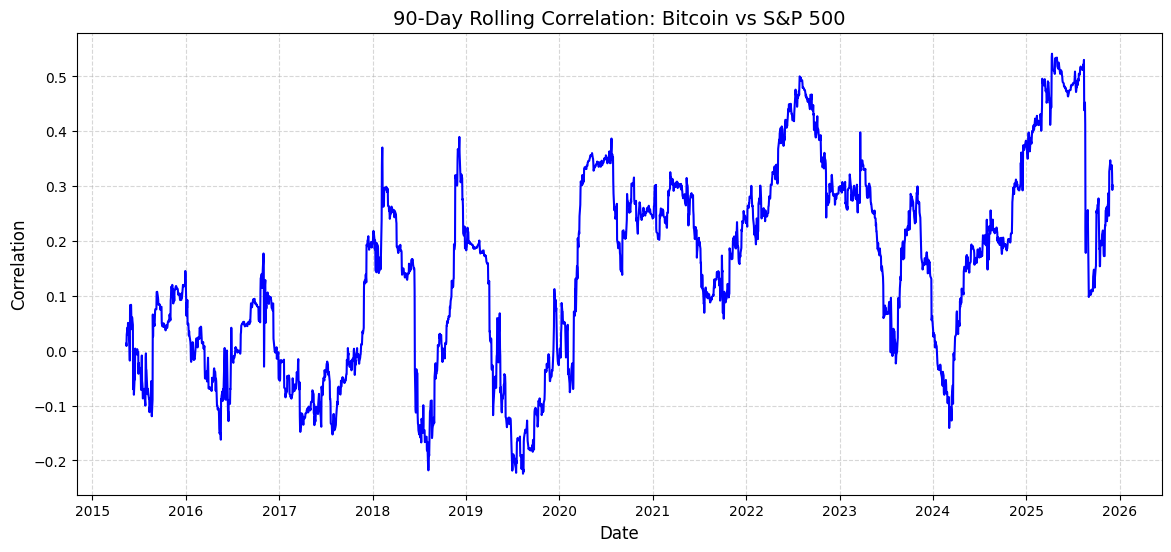

In [33]:
# Plot Rolling Correlation
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['corr_90d'], color='blue')

plt.title("90-Day Rolling Correlation: Bitcoin vs S&P 500", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



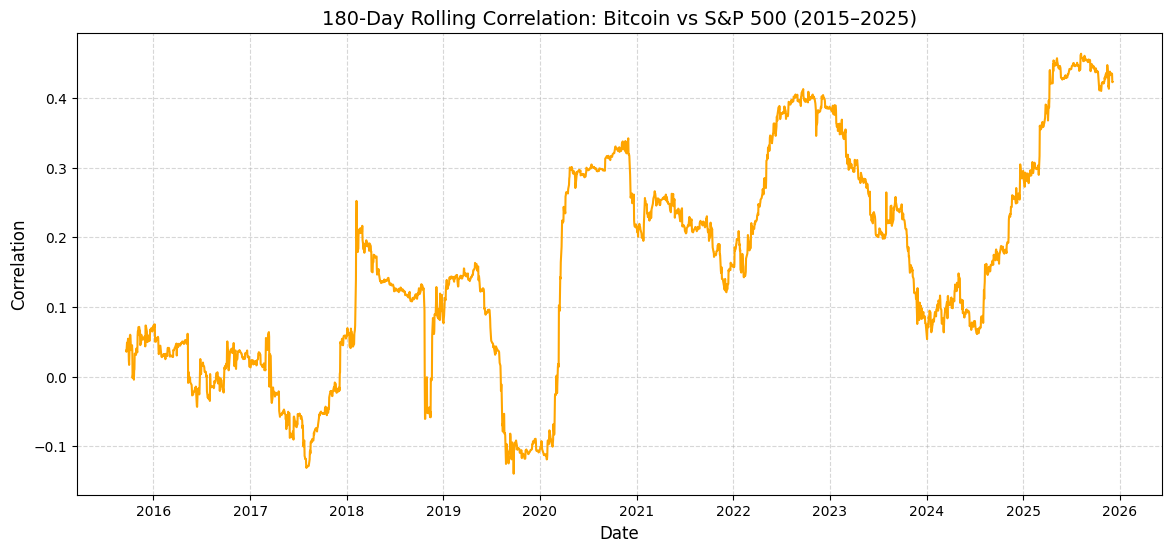

In [34]:
# 180-Day Rolling Correlation Plot

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['corr_180d'], color='orange')

plt.title("180-Day Rolling Correlation: Bitcoin vs S&P 500 (2015–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation", fontsize=12)
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

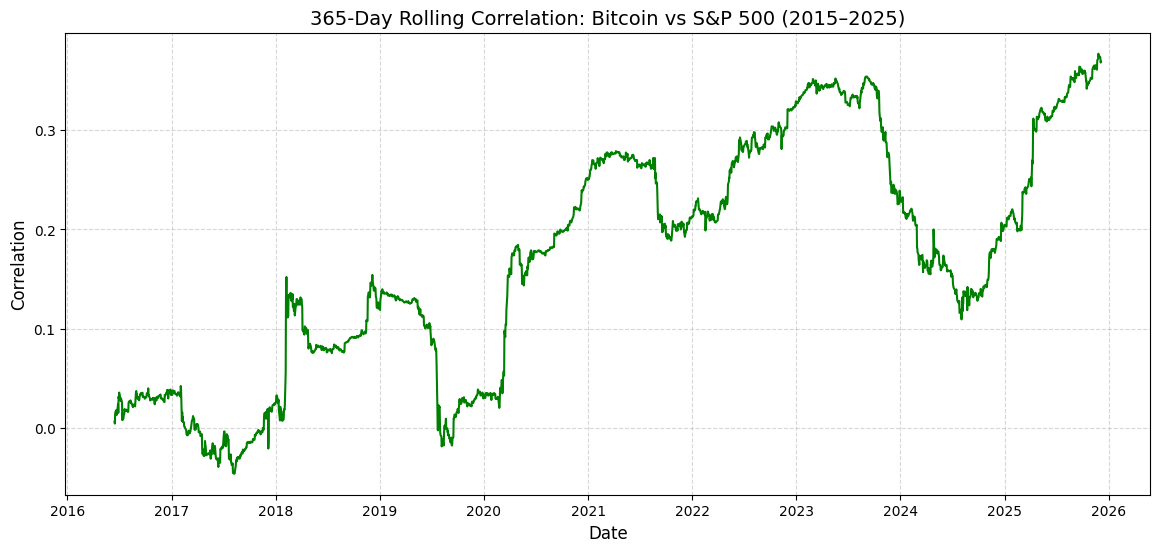

In [ ]:
# 365-Day Rolling Correlation Plot

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['corr_365d'], color='green')

plt.title("365-Day Rolling Correlation: Bitcoin vs S&P 500 (2015–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, linestyle='--', alpha=0.5)

plt.show()


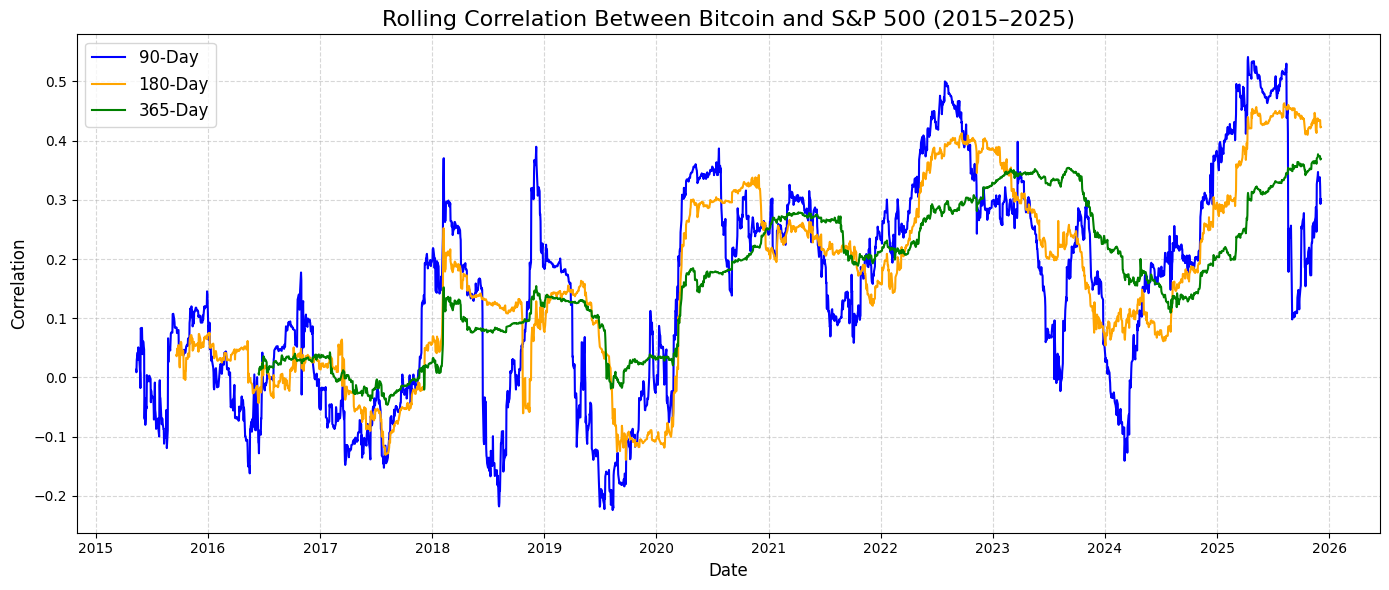

In [36]:
plt.figure(figsize=(14,6))

plt.plot(df['Date'], df['corr_90d'], label='90-Day', color='blue', linewidth=1.5)
plt.plot(df['Date'], df['corr_180d'], label='180-Day', color='orange', linewidth=1.5)
plt.plot(df['Date'], df['corr_365d'], label='365-Day', color='green', linewidth=1.5)

plt.title("Rolling Correlation Between Bitcoin and S&P 500 (2015–2025)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Correlation", fontsize=12)

import matplotlib.dates as mdates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


